code by **PAUL ANTONY**

**Importing necessary libraries and dataset from repository.**
Dataset was firstly combined and afterwards cleaned within the team. Following Hypothesis 2 "Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles." will be checked within this Python File.


In [189]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from tabulate import tabulate
import re
from scipy import stats
import matplotlib.pyplot as plt

#loading our cleaned dataset
df = pd.read_csv('combined_themepark_dataset.csv')
df_original_len = len(df)
print('Original length of dataframe:', df_original_len)

Original length of dataframe: 15443


In [190]:
df.head(1)

,date,profile,message,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,link_posts,picture_posts,video_posts,profile_id,post_id,link
0,12/31/23 9:40 PM,Wild Adventures Theme Park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16,2,2,2,"1,09E+12","1,09E+12",13,NaN,1.0,NaN,84679583132,84679583132_770120045161180,https://www.facebook.com/617429960430190/posts...


**Main Research Question of the Report:** What strategies can US theme parks employ to enhance audience engagement based on insights from performance analysis on Facebook posts? <br>
**Sub-Research Question for Hypothesis 2:** What impact do different types of posts (link, picture, video) have on the engagement levels of US Theme Park Facebook profiles? 

# Testing Hypothesis 2

* H0: Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.
* HA: Posts including pictures and videos generate lower engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.

In [191]:
#check if there are rows without data
df.isnull().sum()

date                         0
profile                      0
message                      0
nr_reactions                 0
nr_comments                  0
nr_shares                    0
comments/post                0
post_interaction_rate        0
engagement                   0
nr_likes                     0
link_posts               14888
picture_posts             3881
video_posts              12964
profile_id                   0
post_id                      0
link                         0
dtype: int64

In [192]:
#check data types
df.dtypes

date                      object
profile                   object
message                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate     object
engagement                object
nr_likes                   int64
link_posts               float64
picture_posts            float64
video_posts              float64
profile_id                object
post_id                   object
link                      object
dtype: object

In [193]:
#list of column names to drop
columns_to_drop = ['message', 'date', 'profile_id', 'post_id', 'link',]
#remove specified columns
df = df.drop(columns=columns_to_drop)

When examining the data type, it was found that there are a lot of missing values in the columns 'picture_posts' and 'video_posts'. This has to do with the fact that if it was a picture post, for example, the value 1 was assigned, on the other hand a NaN value remained. 

As a next log-safe step, I will now generate a new feature that combines this information. So if it is a picture post, the value 1 is assigned. If it is a video post, the value 2 and if the post does not contain an image or video, the value 3.

In [194]:
#setting conditions for the columns
conditions = [
    ~df['picture_posts'].isna(),  # Not NaN for Picture Posts
    ~df['video_posts'].isna()     # Not NaN for Video-posts
]

#updated values to assign based on the conditions: 1 for picture_posts, 2 for video_posts
values = [1, 2]

#create the new column 'post_type' with an 'other' category for everything else except picture and video posts
df['post_type'] = np.select(conditions, values, default=3)

#display the first few rows of the dataframe to verify the new column
df[['picture_posts', 'video_posts', 'post_type']].head()


,picture_posts,video_posts,post_type
0,1.0,NaN,1
1,NaN,NaN,3
2,NaN,1.0,2
3,1.0,NaN,1
4,NaN,1.0,2


In [195]:
#counting the occurrences of 1, 2, and 3 in the 'post_type' column
post_type_counts = df['post_type'].value_counts()
#displaying the counts
print(post_type_counts)

post_type
1    11562
2     2479
3     1402
Name: count, dtype: int64


So we can see, that there are `11562` columns containing picture_posts, `2479` columns containing video_posts and `1402` without any of those.

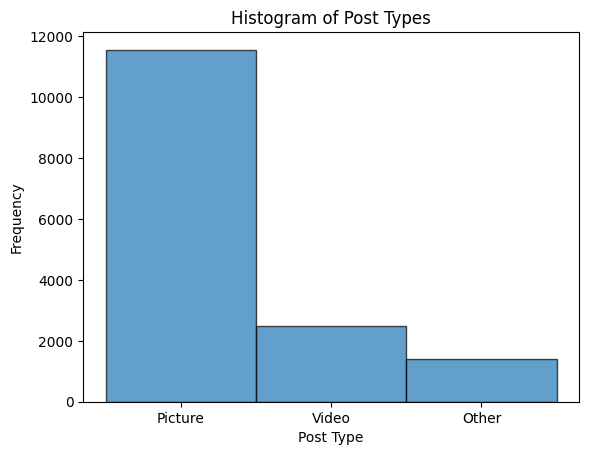

In [196]:
#plotting the histogram for the 'post_type' column
plt.hist(df['post_type'], bins=[0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)

#setting the x-ticks to correspond to the updated post types
plt.xticks(ticks=[1, 2, 3], labels=['Picture', 'Video', 'Other'])

#setting title and labels
plt.title('Histogram of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Frequency')

#displaying the plot
plt.show()

In [197]:
#dropping the specified columns from the DataFrame
df = df.drop(columns=['link_posts', 'picture_posts', 'video_posts', 'engagement'])

In [198]:
#display df in a formatted table
print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════════════╤════════════════╤═══════════════╤═════════════╤═════════════════╤═════════════════════════╤════════════╤═════════════╕
│    │ profile                    │   nr_reactions │   nr_comments │   nr_shares │   comments/post │ post_interaction_rate   │   nr_likes │   post_type │
╞════╪════════════════════════════╪════════════════╪═══════════════╪═════════════╪═════════════════╪═════════════════════════╪════════════╪═════════════╡
│  0 │ Wild Adventures Theme Park │             16 │             2 │           2 │               2 │ 1,09E+12                │         13 │           1 │
├────┼────────────────────────────┼────────────────┼───────────────┼─────────────┼─────────────────┼─────────────────────────┼────────────┼─────────────┤
│  1 │ Fun Spot America           │             38 │             1 │           2 │               1 │ 4,17E+11                │         33 │           3 │
├────┼────────────────────────────┼────────────────┼───────────────┼────────

### Check Assumptions for the Two-Sample T-Test and ANOVA:
**Assumptions for Two-Sample T-Test:**
* Independence of Observations: The data in the two groups must be independent of each other, meaning the observations in one group should not influence the observations in the other group.

* Normality: The data in both groups should be approximately normally distributed. This assumption can be relaxed with large sample sizes due to the Central Limit Theorem.

* Homogeneity of Variances (Equal Variances): The variances in the two groups should be roughly equal. If this assumption is not met, a variation of the t-test called Welch’s t-test can be used, which does not assume equal variances.

* Scale of Measurement: The variable being tested should be measured on an interval or ratio scale (i.e., continuous data).

* Random Sampling: The data should be collected from a random sample from the population.

**Assumptions for ANOVA:**
* Independence of Observations: Just like in the two-sample t-test, the observations in each group must be independent of each other.

* Normality: The distribution of the residuals should be approximately normal for each group. This means that the data in each group should come from a population that follows a normal distribution.

* Homogeneity of Variances: The variance among the groups should be approximately equal. This is known as the assumption of homoscedasticity. If this assumption is violated, alternatives like the Welch ANOVA or the Brown-Forsythe test can be considered.

* Random Sampling: Each sample should be an independent random sample from the population.

* Measurement Scale: The dependent variable should be measured at the interval or ratio level.